In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import utils
from sklearn import model_selection
from sklearn import ensemble

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

eps = 1e-7

In [2]:
df = pd.read_hdf('tmp/06.tmp', 'df')
df.head()

,year,cypher_id,1000kHz-LA Impedance,1000kHz-LL Impedance,1000kHz-RA Impedance,1000kHz-RL Impedance,1000kHz-TR Impedance,10m最大歩行速度,10m最大歩行速度_1回目,10m最大歩行速度_2回目,...,高血圧_罹患歴あり,Ｈピロリ抗体判定_補助コメント_nan,Ｈピロリ抗体判定_補助コメント_測定不能,Ｈピロリ抗体濃度_補助コメント_nan,Ｈピロリ抗体濃度_補助コメント_測定不能,Ｍ２ＢＰＧｉ_判定_nan,ﾀｹﾌﾟﾛﾝ、ﾊﾟﾘｴｯﾄ2.その他3.わからない_nan,ﾀｹﾌﾟﾛﾝ、ﾊﾟﾘｴｯﾄ2.その他3.わからない_その他,ﾀｹﾌﾟﾛﾝ、ﾊﾟﾘｴｯﾄ2.その他3.わからない_わからない,ﾀｹﾌﾟﾛﾝ、ﾊﾟﾘｴｯﾄ2.その他3.わからない_ｵﾒﾌﾟﾗｰﾙ、ﾀｹﾌﾟﾛﾝ、ﾊﾟﾘｴｯﾄ
53,2005-01-01,17Afbh8E,287.381835,218.354021,281.305393,216.9228,16.926585,4.572307,4.206414,4.150884,...,0,1,0,1,0,1,1,0,0,0
124,2005-01-01,2oCe7U5f,287.381835,218.354021,281.305393,216.9228,16.926585,4.572307,4.206414,4.150884,...,0,1,0,1,0,1,1,0,0,0
128,2005-01-01,2qeXpjso,287.381835,218.354021,281.305393,216.9228,16.926585,4.572307,4.206414,4.150884,...,0,1,0,1,0,1,1,0,0,0
175,2005-01-01,3jLE7iLx,287.381835,218.354021,281.305393,216.9228,16.926585,4.572307,4.206414,4.150884,...,0,1,0,1,0,1,1,0,0,0
177,2005-01-01,3l2MvLB8,287.381835,218.354021,281.305393,216.9228,16.926585,4.572307,4.206414,4.150884,...,0,1,0,1,0,1,1,0,0,0


In [3]:
mask = ['year', 'cypher_id', 'diag_DM']
X = df[df.columns ^ mask]
Y = np.eye(2)[df['diag_DM'].astype(np.int)]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y)

In [17]:
################################################################################
# dropout feature ranking
################################################################################
#
# helper functions
#
def concrete_dropout_neuron(dropout_p, shape, temp=1.0 / 10.0):
    unif_noise = tf.random_uniform(shape)
    approx = (
          tf.log(dropout_p + eps)
        - tf.log(1. - dropout_p + eps)
        + tf.log(unif_noise + eps)
        - tf.log(1. - unif_noise + eps)
    )
    approx_output = tf.sigmoid(approx / temp)
    return 1. - approx_output

def eval_regularizer(logit_p):
    dropout_p = tf.sigmoid(logit_p)
    loss = 1. - dropout_p
    return loss

def annealing(epoch, epoches):
    rw_max = epoches / 2
    if epoch > rw_max:
        return 1.
    return epoch * 1.0 / rw_max

#
# construct graph
#
x               = tf.placeholder(tf.float32, shape=[None, 5650])
t               = tf.placeholder(tf.float32, shape=[None, 2])
is_training     = tf.placeholder(tf.bool)
is_pretrain     = tf.placeholder(tf.bool)
annealed_lambda = tf.placeholder(tf.float32)

logit_p            = tf.Variable(tf.zeros((5650,)))
expanded_logit_p   = logit_p[tf.newaxis, :]
expanded_dropout_p = tf.sigmoid(expanded_logit_p)
bernoulli_approx   = concrete_dropout_neuron(expanded_dropout_p, tf.shape(x))
noised_x           = x * bernoulli_approx

h = tf.cond(is_pretrain, lambda:x, lambda:noised_x)
h = tf.layers.dense              (h, 170, tf.nn.relu)
h = tf.layers.batch_normalization(h, training=is_training)
h = tf.layers.dropout            (h, 0.5, training=is_training)
h = tf.layers.dense              (h, 170, tf.nn.relu)
h = tf.layers.batch_normalization(h, training=is_training)
h = tf.layers.dropout            (h, 0.5, training=is_training)
y = tf.layers.dense              (h, 2, tf.nn.softmax)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
importance_vector  = tf.sigmoid(-logit_p)

regularizer_coef   = 0.1
regularizer_loss   = regularizer_coef * tf.reduce_sum(eval_regularizer(logit_p))
crossentropy_loss  = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y + eps), axis=1))
loss               = tf.cond(is_pretrain, 
                             lambda: crossentropy_loss, 
                             lambda: crossentropy_loss + annealed_lambda * regularizer_loss)
train_step         = tf.train.AdamOptimizer().minimize(loss)

batch_size = 200
n_batches  = len(X_train) // batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    #
    # phase: pretraining
    #
    epoches = 200
    for epoch in tqdm(range(epoches)):
        X_, Y_ = utils.shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end   = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                is_training: True,
                is_pretrain: True,
                annealed_lambda: annealing(epoch, epoches),
                })

        print(epoch, sess.run([loss, accuracy], feed_dict={
            x: X_test,
            t: Y_test,
            is_training: False,
            is_pretrain: True,
            annealed_lambda: annealing(epoch, epoches),
            }))

    #
    # phase: learning prob
    #
    epoches = 500
    for epoch in tqdm(range(epoches)):
        X_, Y_ = utils.shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end   = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                is_training: True,
                is_pretrain: False,
                annealed_lambda: annealing(epoch, epoches),
                })

        # print(epoch, sess.run([loss, accuracy], feed_dict={
        #     x: X_test,
        #     t: Y_test,
        #     is_training: False,
        #     is_pretrain: False,
        #     annealed_lambda: annealing(epoch, epoches),
        #     }))

    nn_importance_vector = sess.run(importance_vector, feed_dict={
            x: X_test,
            t: Y_test,
            is_training: False,
            is_pretrain: False,
            annealed_lambda: 1.0,
            })

0 [10.602686, 0.3421875]
1 [13.42839, 0.166875]
2 [3.0825858, 0.80875]
3 [1.4405549, 0.910625]
4 [1.4355178, 0.9109375]
5 [1.420407, 0.911875]
6 [1.420407, 0.911875]
7 [1.4405546, 0.910625]
8 [1.7629169, 0.890625]
9 [1.8233595, 0.886875]
10 [1.9039501, 0.881875]
11 [2.2565336, 0.86]
12 [7.0768514, 0.5609375]
13 [1.4455917, 0.9103125]
14 [1.4506285, 0.91]
15 [1.4909238, 0.9075]
16 [1.5161083, 0.9059375]
17 [1.430481, 0.91125]
18 [1.4506285, 0.91]
19 [1.5009977, 0.906875]
20 [1.4455917, 0.9103125]
21 [2.3874242, 0.851875]
22 [1.6118097, 0.9]
23 [1.4455916, 0.9103125]
24 [1.4455916, 0.9103125]
25 [2.5537107, 0.8415625]
26 [1.4657393, 0.9090625]
27 [1.7679536, 0.8903125]
28 [1.6067727, 0.9003125]
29 [1.5715142, 0.9025]
30 [1.4858868, 0.9078125]
31 [3.0400953, 0.81125]
32 [1.5110714, 0.90625]
33 [2.1507583, 0.8665625]
34 [1.5614406, 0.903125]
35 [2.1205244, 0.8684375]
36 [1.6369941, 0.8984375]
37 [1.5715142, 0.9025]
38 [2.0361528, 0.8734375]
39 [1.7348965, 0.8921875]
40 [6.475229, 0.598125]

delta_lm_AUC          0.001090
lm_AUC                0.000776
RCNH                  0.000745
delta_RCNH            0.000501
delta_lg_AUC          0.000429
lm_AUC_再測定            0.000419
RULE                  0.000332
lg_AUC_再測定            0.000312
lg_AUC                0.000308
DiagRuleCode          0.000293
民間療法_健康器具_金額          0.000259
ルミノール_PH              0.000243
ルミノール再測定_PH           0.000241
delta_DiagRuleCode    0.000224
ルミノール_PH_1            0.000195
ルミノール_PH_3            0.000187
delta_ルミノール_PH        0.000167
NextAimWalk           0.000162
OZ_HE_CFI             0.000158
白血球数                  0.000147
dtype: float32

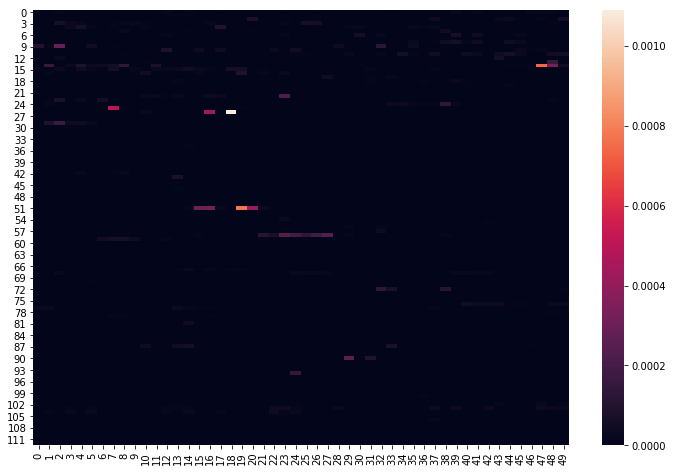

In [18]:
################################################################################
# feature importance by VariationalDropoutNN
################################################################################
plt.figure(figsize=(12, 8))
sns.heatmap(np.reshape(nn_importance_vector, (113, -1)))

imp = pd.Series(nn_importance_vector)
imp.index = pd.Series(df[df.columns ^ mask].columns)
imp.sort_values(ascending=False)[:20]

/home/hiroyam/.local/share/virtualenvs/data-u-kyoto-feature-_MSQN99e/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


四肢血圧_LbaPWV         0.005939
内脂肪レベル              0.004988
健康状況_医師_脂質異常症_なし    0.003971
左半身-X_250kHz        0.003890
左足-筋肉量              0.003876
健康状況_服薬_高血圧治療薬      0.003858
体重                  0.003643
健康状況_医師_高血圧_治療中     0.003612
プロリン                0.003527
血清鉄                 0.003339
両足-X_250kHz         0.003313
左足-R_50kHz          0.003311
左腕-R_50kHz          0.003274
両足-R_50kHz          0.003176
クレアチニン              0.003176
収縮期血圧               0.003079
四肢血圧_RABI           0.002903
2014PG1             0.002838
高血圧治療薬              0.002789
総コレステロール            0.002785
dtype: float64


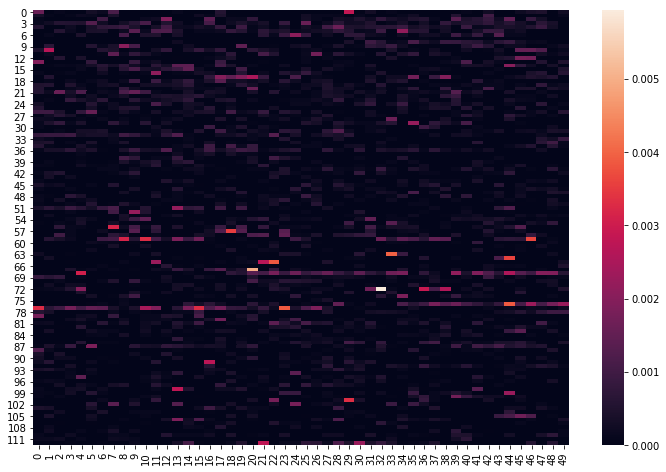

In [11]:
################################################################################
# feature importance by RandomForest
################################################################################
clf = ensemble.RandomForestClassifier()
clf.fit(X_train, Y_train)
plt.figure(figsize=(12, 8))
sns.heatmap(np.reshape(clf.feature_importances_, (113, -1)))
    
imp = pd.Series(clf.feature_importances_)
imp.index = pd.Series(df[df.columns ^ mask].columns)
print(imp.sort_values(ascending=False)[:20])